In [1]:
import sys 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
sys.path.insert(0, "../../")
import spycone as spy

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/nfs/home/students/chit/.conda/envs/nease/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Gene-level workflow

## Prepare the dataset

We use a time series dataset of influenza infection with 9 time points. 

In [2]:
#sample data
import os
os.chdir("/nfs/proj/spycone/")


influ = pd.read_csv("./spycone_pkg/data/covid_hs/normticonerhino_wide.csv", dtype={'entrezid': str})
gene_list = influ['entrezid'] 
symbs = influ['symbol']

flu_ts = influ.iloc[:,3:] ##filter out the entrez id and gene id column


Import expression data with `DataSet` which stores the count matrix, list of gene ID, number of time points, and number of replicates. \
`ts` : time series data values with columns as each sample e.g. the order of the columns should be **sample1_rep1**, **sample1_rep2**, **sample2_rep1**, **sample2_rep2** and so on.... \
`gene_id` : the pandas series or list of gene id (can be entrez gene id or ensembl gene id) \
`species` : specify the species ID \
`reps1` : Number of replicates \
`timepts` : Number of time points \
`discreization_steps` : Steps to discretize the data values

In [3]:
flu_dset = spy.dataset(ts=flu_ts, 
                        gene_id = gene_list, 
                        species=9606,
                        keytype="entrezgeneid",
                        reps1 = 5, 
                        timepts = 9,
                        discretization_steps = [20,20])

Import biological network of your choice with `BioNetwork`, Spycone provides Biogrid, IID network in entrez ID as node name. Please specify the keytype if you are using a different ID.

In [4]:
bionet = spy.BioNetwork("human", data=(('weight',float),))

## Preprocessing

Filtering out genes that has expression across all time points lower than 1. By giving the biological network, it removes genes from the dataset that are not in the network.

In [5]:
spy.preprocess(flu_dset)

Input data dimension: (5, 19463, 9)
Removed 0 with 0 values.
Filtered data: (5, 19463, 9)


In [6]:
import networkx as nx
path = os.path.join("./spycone_pkg/spycone",f'data/network/9606_biogrid_entrez.tab')
g = nx.read_edgelist(path=path)


## Clustering

`clustering` create clustering object that provides varies algorithms and result storage.

In [7]:
asclu = spy.clustering(flu_dset, algorithm='hierarchical', metrics="correlation", input_type="expression", n_clusters=10, composite=False)
c = asclu.find_clusters()

clustering took 40.93573355674744s. 


visualizing clustering

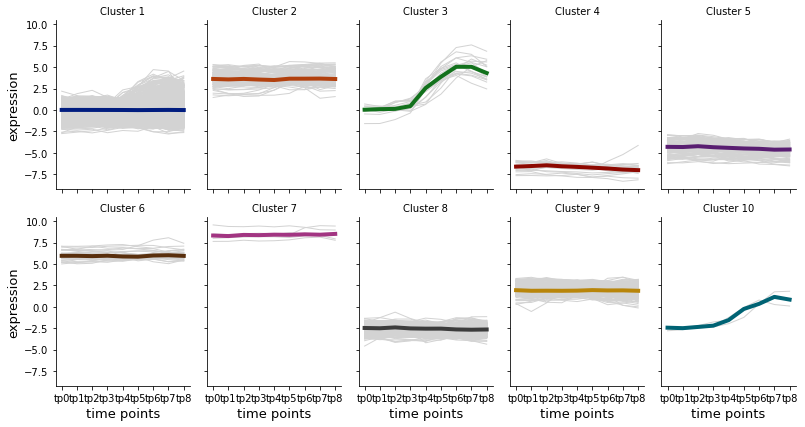

In [8]:
%matplotlib inline
spy.vis_all_clusters(asclu, col_wrap=5)

## Gene set enrichment analysis

Perform gene set enrichment analysis using `clusters_gsea`. Change the gene_sets parameter into the choice of your knowledge base or gene set database, e.g. Reactome, KEGG, etc. Use `spy.list_genesets` to view the available knowledge base.

In [9]:
spy.list_genesets("human")[0:5]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues']

In [10]:
asclu_go, _ = spy.clusters_gsea(flu_dset, 9606, method="gseapy", gene_sets = ['GO_Biological_Process_2018'])

2022-04-27 21:30:49,640 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05
2022-04-27 21:30:55,369 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05
2022-04-27 21:31:01,358 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05
2022-04-27 21:31:06,770 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05
2022-04-27 21:31:12,267 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05
2022-04-27 21:31:17,999 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


---------Gene Set Enrichment Result---------

Method: gseapy Database: ['GO_Biological_Process_2018']
Cluster 1  found enriched in 65 terms.
Cluster 9  found enriched in 0 terms.
Cluster 2  found enriched in 0 terms.
Cluster 8  found enriched in 0 terms.
Cluster 4  found enriched in 0 terms.
Cluster 6  found enriched in 0 terms.
Cluster 5  found enriched in 0 terms.
Cluster 3  found enriched in 133 terms.
Cluster 10  found enriched in 103 terms.
Cluster 7  found enriched in 17 terms.
-----END-----


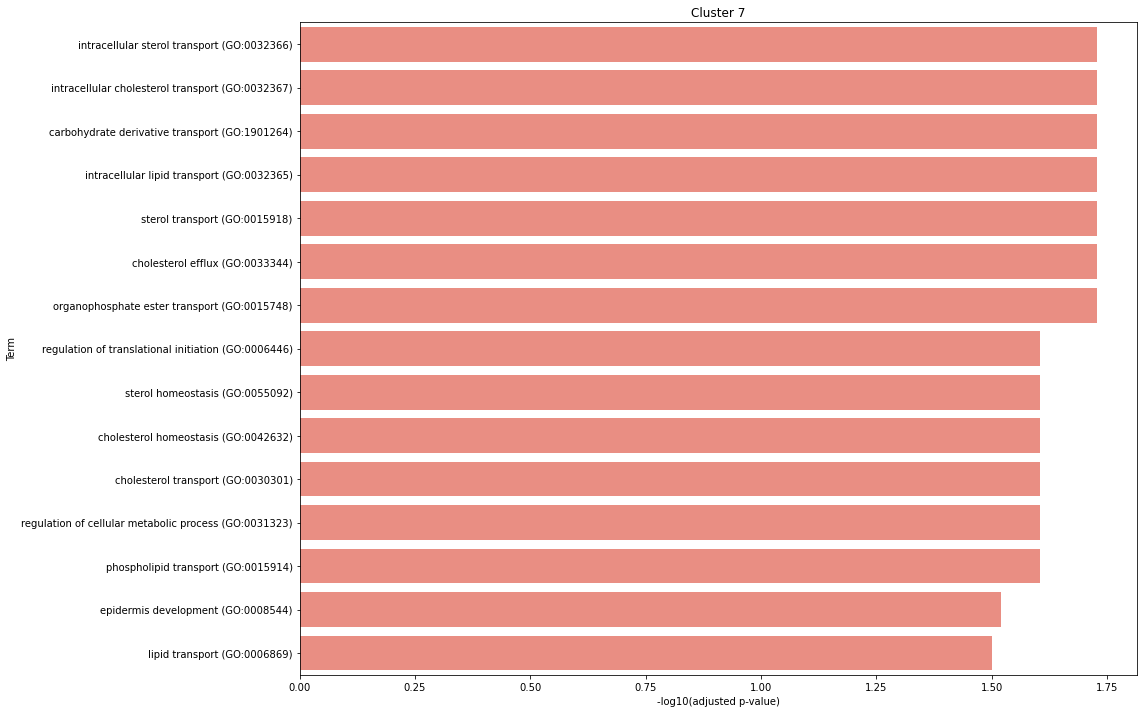

In [11]:
spy.gsea_plot(asclu_go, cluster=7, nterms=15)

## Run DOMINO

In [12]:
mods = spy.run_domino(asclu, network_file=bionet, output_file_path="./slices/newslices.txt")

start running DOMINO...
---------Network enrichment Result---------

Cluster 1 found 2 module(s).
Cluster 9 found 8 module(s).
Cluster 2 found 4 module(s).
Cluster 8 found 8 module(s).
Cluster 4 found 0 module(s).
Cluster 6 found 4 module(s).
Cluster 5 found 4 module(s).
Cluster 3 found 1 module(s).
Cluster 10 found 1 module(s).
Cluster 7 found 2 module(s).
-----END-----


To visualize the modules, use `vis_modules`. 

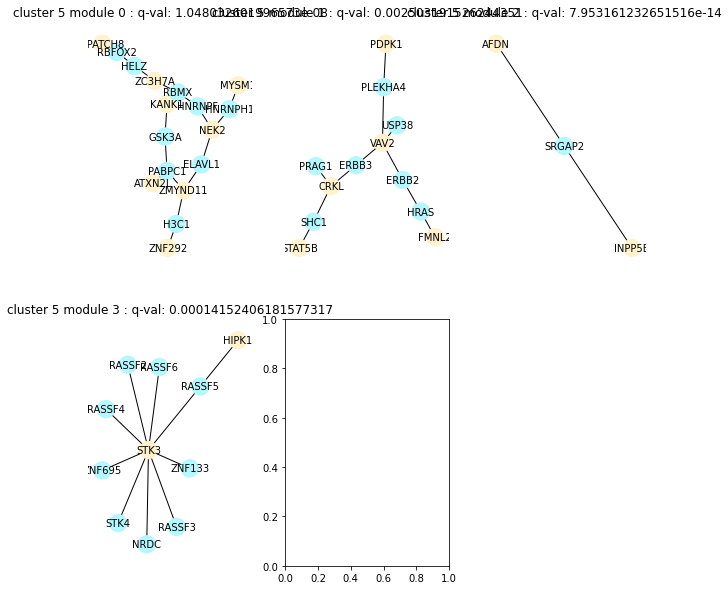

In [19]:
%matplotlib inline
spy.vis_modules(mods, flu_dset, cluster=5, size=0)

It is also possible to visualize modules with javascript, use `vis_better_modules` and input a desired directory, the function will generate networks with dot format (Graphviz) (https://github.com/pydot/pydot).

vis_better_modules(flu_dset, mods, cluster=5, dir='/path/to/file')